In [1]:
import itertools
import warnings
from collections import deque
from typing import Dict, Tuple

import multiprocess as mp
import pandas as pd
import scipy.stats as stats
from tqdm.notebook import tqdm

from edgedroid.models import *
from sampling_util import *

reference_name = "Ideal"


def experimental_run(
        rtt: float,
        proc_t: float,
        P0: float,
        Pc: float,
        task_steps: int,
        repetition: int,
):
    tc = rtt - proc_t
    w0 = 3.0
    min_sr = 0.5
    alpha = 3.0

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        ground_truth = ExpKernelRollingTTFETModel(neuroticism=1.0)
        samplers: Dict[str, ConstantRTTSampler] = {
            "Greedy"                         : GreedyConstantRTTSampler(
                t_net=tc,
                t_proc=proc_t,
                P0=P0,
                Pc=Pc
            ),
            "Wang et. al. 2019\nGaussian fit": JunjuesConstantRTTSampler(
                cdf_estimator=FittedNaiveExecutionTimeModel(dist=stats.norm),
                min_sr=min_sr,
                alpha=alpha,
                t_net=tc,
                t_proc=proc_t,
                P0=P0,
                Pc=Pc
            ),
            "Sample-count-optimized\naperiodic"   : SamplingOptimumSampler(
                estimator=ExpKernelRollingTTFETModel(neuroticism=1.0),
                max_wait=w0,
                t_net=tc,
                t_proc=proc_t,
                P0=P0,
                Pc=Pc
            ),
            "Energy-optimized\naperiodic"     : EnergyOptimumSampler(
                estimator=ExpKernelRollingTTFETModel(neuroticism=1.0),
                t_net=tc,
                t_proc=proc_t,
                P0=P0,
                Pc=Pc
            ),
            reference_name                   : IdealConstantRTTSampler(
                t_net=tc,
                t_proc=proc_t,
                P0=P0,
                Pc=Pc
            )
        }

    rows = deque()

    for name, sampler in samplers.items():
        ground_truth.reset()
        prev_ttf = rtt

        for step in range(1, task_steps + 1):
            exec_time = ground_truth.advance(prev_ttf).get_execution_time()
            step_results: StepResults = sampler.sample_step(prev_ttf, exec_time)

            rows.append(dict(
                sampler=name,
                repetition=repetition,
                **step_results._asdict(),
            ))
            prev_ttf = step_results.ttf

    df = pd.DataFrame(rows)
    df["sampler"] = df["sampler"].astype(pd.CategoricalDtype(samplers.keys(), ordered=False))
    return df


processing_delay = 0.3
rtts = np.array([0.3375, 0.675, 1.25, 2.5, 5.0])
net_delays = rtts - processing_delay

task_steps = 100
repetitions = 100

P0 = 0.015
Pc = 0.045

combinations = list(itertools.product(
    rtts,
    range(1, repetitions + 1)
))

results = deque()

with tqdm(total=len(combinations)) as bar, mp.Pool() as pool:
    def _callback(df: pd.DataFrame):
        results.append(df)
        bar.update()


    def _errback(error):
        print(error)
        raise error


    for rtt, rep in combinations:
        pool.apply_async(
            experimental_run,
            args=(rtt, processing_delay, P0, Pc, task_steps, rep),
            callback=_callback,
            error_callback=_errback,
        )

    pool.close()
    pool.join()

results = pd.concat(results, ignore_index=True)
results

  0%|          | 0/500 [00:00<?, ?it/s]

,sampler,repetition,execution_time,duration,rtt,ttf,wait_time,num_samples,energy,P0,Pc,t0,tc
0,Greedy,5,5.739383,6.412500,0.3375,0.673117,3.356172e-01,19,0.117563,0.015,0.045,0.3,0.0375
1,Greedy,5,5.335999,5.737500,0.3375,0.401501,6.400065e-02,17,0.105188,0.015,0.045,0.3,0.0375
2,Greedy,5,4.948992,5.400000,0.3375,0.451008,1.135079e-01,16,0.099000,0.015,0.045,0.3,0.0375
3,Greedy,5,6.138334,6.750000,0.3375,0.611666,2.741665e-01,20,0.123750,0.015,0.045,0.3,0.0375
4,Greedy,5,7.244787,7.762500,0.3375,0.517713,1.802126e-01,23,0.142313,0.015,0.045,0.3,0.0375
...,...,...,...,...,...,...,...,...,...,...,...,...,...
249995,Ideal,98,6.736044,11.736044,5.0000,5.000000,0.000000e+00,1,0.317041,0.015,0.045,0.3,4.7000
249996,Ideal,98,9.397580,14.397580,5.0000,5.000000,0.000000e+00,1,0.356964,0.015,0.045,0.3,4.7000
249997,Ideal,98,7.106536,12.106536,5.0000,5.000000,8.881784e-16,1,0.322598,0.015,0.045,0.3,4.7000
249998,Ideal,98,9.213385,14.213385,5.0000,5.000000,0.000000e+00,1,0.354201,0.015,0.045,0.3,4.7000


In [2]:
mean_energy_per_step = (
    results
    .groupby(["sampler", "rtt", "repetition"])
    ["energy"]
    .mean()
    # .groupby(["sampler", "rtt"])
    # .mean()
)

mean_energy_per_step

sampler  rtt     repetition
Greedy   0.3375  1             0.104012
                 2             0.100980
                 3             0.108343
                 4             0.108034
                 5             0.111870
                                 ...   
Ideal    5.0000  96            0.319374
                 97            0.314441
                 98            0.321070
                 99            0.325285
                 100           0.317337
Name: energy, Length: 2500, dtype: float64

In [3]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.ticker as tkr
import pandas as pd
import seaborn as sns

sns.set_style("whitegrid")
sns.set_context("paper", font_scale=2)
sns.set_palette("Dark2")

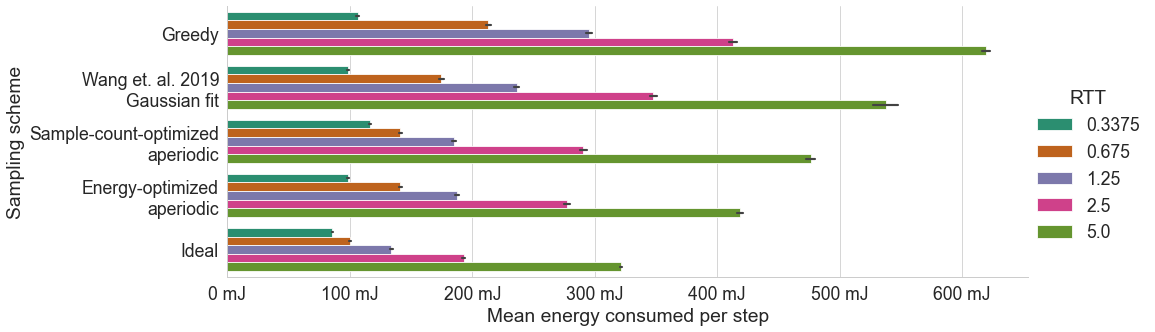

In [4]:
plot_data = mean_energy_per_step.reset_index()
# plot_data["rtt"] = plot_data["rtt"].apply(lambda s: f"{s:0.3f} s")

height = 4

fg = sns.catplot(
    kind="bar",
    data=plot_data,
    x="energy",
    y="sampler",
    hue="rtt",
    aspect=3,
    # aspect=12 / height,
    # height=height,
    # legend_out=False,
)
fg.set_axis_labels("Mean energy consumed per step", "Sampling scheme")
fg.legend.set_title("RTT")
for ax in fg.axes.flat:
    ax.xaxis.set_major_formatter(tkr.FuncFormatter(lambda x, p: f"{x * 1000:1.0f} mJ"))
plt.show()

# TODO: remove Wang, estimator, Moothedath original

In [5]:
import pingouin as pg

ix = pd.IndexSlice


def diff_wrt_ref_rtt(df: pd.DataFrame, column: str) -> pd.DataFrame:
    ref_energy = df.loc[df["sampler"] == reference_name, column].to_numpy()
    ref_mean = ref_energy.mean()

    def diff_wrt_ref(samples: pd.Series) -> pd.Series:
        ttest = pg.ttest(samples.to_numpy(), ref_energy, alternative="two-sided")
        diff_raw = samples.mean() - ref_mean
        diff = diff_raw / ref_mean
        ci = ttest.at["T-test", "CI95%"]

        pval = ttest.at["T-test", "p-val"]
        sig_pval = pval < 0.05

        return pd.Series({
            "diff"     : diff,
            "diff_raw" : diff_raw,
            "p-val"    : pval,
            "p < 0.05" : sig_pval,
            "CI95_Low" : ci[0] / ref_mean,
            "CI95_High": ci[1] / ref_mean}, name="Result")

    return df.groupby("sampler")[column].apply(diff_wrt_ref)


energy_diff = mean_energy_per_step.reset_index().groupby(["rtt"]).apply(lambda df: diff_wrt_ref_rtt(df, "energy")).stack().stack().unstack(
    level=1).reset_index()
energy_diff = energy_diff[energy_diff["sampler"] != reference_name]
energy_diff["sampler"] = energy_diff["sampler"].cat.remove_unused_categories()
energy_diff

/Users/molguin/.venvs/EdgeDroid/lib/python3.10/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


,rtt,sampler,diff,diff_raw,p-val,p < 0.05,CI95_Low,CI95_High
0,0.3375,Greedy,0.238625,0.020477,0.0,True,0.233068,0.233068
1,0.3375,Wang et. al. 2019\nGaussian fit,0.145615,0.012496,0.0,True,0.116534,0.116534
2,0.3375,Sample-count-optimized\naperiodic,0.356564,0.030598,0.0,True,0.349601,0.349601
3,0.3375,Energy-optimized\naperiodic,0.148492,0.012742,0.0,True,0.116534,0.116534
5,0.6750,Greedy,1.126554,0.112978,0.0,True,1.096857,1.196571
6,0.6750,Wang et. al. 2019\nGaussian fit,0.742313,0.074444,0.0,True,0.698,0.797714
7,0.6750,Sample-count-optimized\naperiodic,0.408835,0.041001,0.0,True,0.398857,0.398857
8,0.6750,Energy-optimized\naperiodic,0.407841,0.040901,0.0,True,0.398857,0.398857
10,1.2500,Greedy,1.203085,0.161144,0.0,True,1.194546,1.194546
11,1.2500,Wang et. al. 2019\nGaussian fit,0.765701,0.10256,0.0,True,0.746592,0.746592


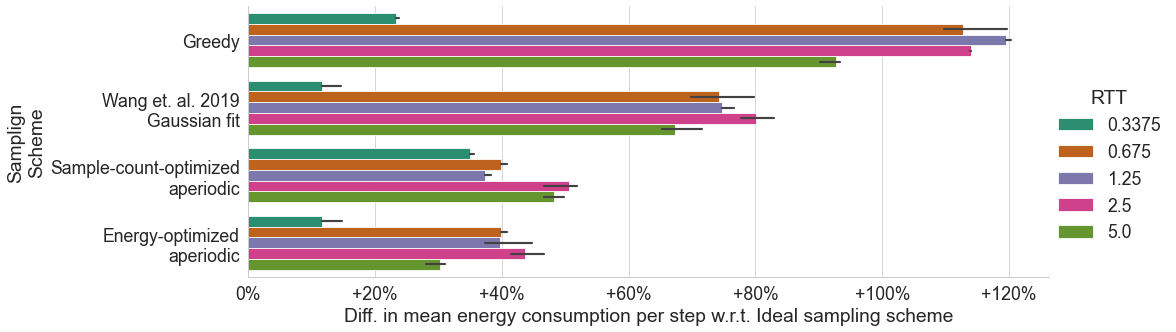

In [6]:
import matplotlib.ticker as tkr

plot_data = energy_diff.set_index(["sampler", "rtt"])[["CI95_Low", "CI95_High", "diff"]].stack().reset_index().rename(
    columns={0: "values"})

fg = sns.catplot(
    kind="bar",
    data=plot_data,
    estimator=lambda e: sorted(e)[1],
    errorbar=lambda e: (min(e), max(e)),
    y="sampler",
    hue="rtt",
    x="values",
    aspect=3,
    # aspect=12 / height,
    # height=height,
)
fg.legend.set_title("RTT")
fg.set_axis_labels(f"Diff. in mean energy consumption per step w.r.t. {reference_name} sampling scheme", "Samplign\nScheme")
# fg.set(xticks=np.linspace(-0.25, 0, 6))
for ax in fg.axes.flat:
    ax.xaxis.set_major_formatter(tkr.FuncFormatter(lambda x, p: f"{x:+0.0%}" if x != 0.0 else "0%"))
plt.show()

In [7]:
mean_samples_per_step = (
    results
    .groupby(["sampler", "rtt", "repetition"])
    ["num_samples"]
    .mean()
    # .groupby(["sampler", "rtt"])
    # .mean()
)

mean_samples_per_step

sampler  rtt     repetition
Greedy   0.3375  1             16.81
                 2             16.32
                 3             17.51
                 4             17.46
                 5             18.08
                               ...  
Ideal    5.0000  96             1.00
                 97             1.00
                 98             1.00
                 99             1.00
                 100            1.00
Name: num_samples, Length: 2500, dtype: float64

In [8]:
mean_samples_per_step.groupby(["sampler", "rtt"]).mean()

sampler                            rtt   
Greedy                             0.3375    17.1780
                                   0.6750     9.9773
                                   1.2500     6.2452
                                   2.5000     3.9903
                                   5.0000     2.8691
Wang et. al. 2019\nGaussian fit    0.3375     9.6309
                                   0.6750     6.3447
                                   1.2500     4.2313
                                   2.5000     2.9144
                                   5.0000     2.1471
Sample-count-optimized\naperiodic  0.3375     1.8884
                                   0.6750     1.8986
                                   1.2500     1.9254
                                   2.5000     2.0266
                                   5.0000     1.8428
Energy-optimized\naperiodic        0.3375     5.9075
                                   0.6750     2.2898
                                   1.2500     1.6829
    

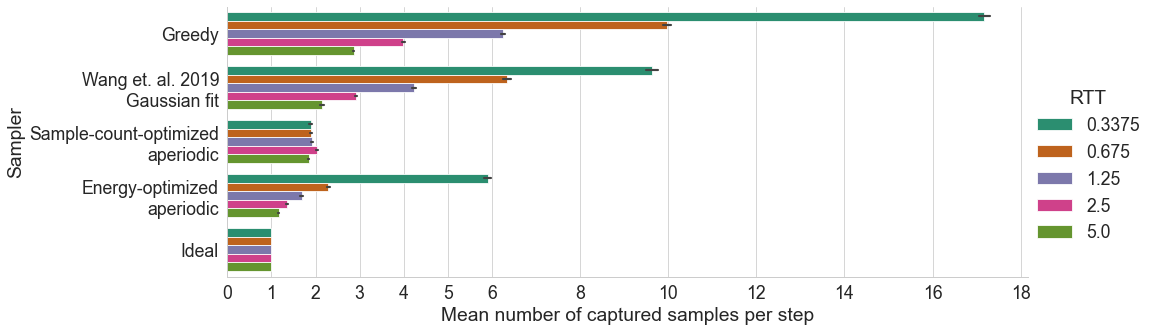

In [9]:
plot_data = mean_samples_per_step.reset_index()
# plot_data["rtt"] = plot_data["rtt"].apply(lambda s: f"{s:0.2f} s")

fg = sns.catplot(
    kind="bar",
    data=plot_data,
    x="num_samples",
    y="sampler",
    hue="rtt",
    aspect=3,
)
fg.set_axis_labels("Mean number of captured samples per step", "Sampler")
fg.set(xticks=list(np.linspace(0, 5, 6)) + list(np.linspace(6.0, 18.0, 7)))
fg.legend.set_title("RTT")
for ax in fg.axes.flat:
    ax.xaxis.set_major_formatter(tkr.FuncFormatter(lambda x, p: f"{x:0.0f}"))
plt.show()

In [10]:
samples_diff = mean_samples_per_step.reset_index().groupby(["rtt"]).apply(lambda df: diff_wrt_ref_rtt(df, "num_samples")).stack().stack().unstack(
    level=1).reset_index()
samples_diff = samples_diff[samples_diff["sampler"] != reference_name]
samples_diff["sampler"] = samples_diff["sampler"].cat.remove_unused_categories()
samples_diff

/Users/molguin/.venvs/EdgeDroid/lib/python3.10/site-packages/pingouin/parametric.py:261: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  tval, pval = ttest_ind(x, y, equal_var=True, alternative=alternative)
/Users/molguin/.venvs/EdgeDroid/lib/python3.10/site-packages/pingouin/parametric.py:261: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  tval, pval = ttest_ind(x, y, equal_var=True, alternative=alternative)
/Users/molguin/.venvs/EdgeDroid/lib/python3.10/site-packages/pingouin/parametric.py:261: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  tval, pval = ttest_ind(x, y, equal_var=True, alternative=alternative)
/Use

,rtt,sampler,diff,diff_raw,p-val,p < 0.05,CI95_Low,CI95_High
0,0.3375,Greedy,16.178,16.178,0.0,True,16.04,16.31
1,0.3375,Wang et. al. 2019\nGaussian fit,8.6309,8.6309,0.0,True,8.5,8.76
2,0.3375,Sample-count-optimized\naperiodic,0.8884,0.8884,0.0,True,0.86,0.92
3,0.3375,Energy-optimized\naperiodic,4.9075,4.9075,0.0,True,4.82,4.99
5,0.6750,Greedy,8.9773,8.9773,0.0,True,8.88,9.08
6,0.6750,Wang et. al. 2019\nGaussian fit,5.3447,5.3447,0.0,True,5.25,5.44
7,0.6750,Sample-count-optimized\naperiodic,0.8986,0.8986,0.0,True,0.87,0.93
8,0.6750,Energy-optimized\naperiodic,1.2898,1.2898,0.0,True,1.26,1.32
10,1.2500,Greedy,5.2452,5.2452,0.0,True,5.2,5.29
11,1.2500,Wang et. al. 2019\nGaussian fit,3.2313,3.2313,0.0,True,3.19,3.28


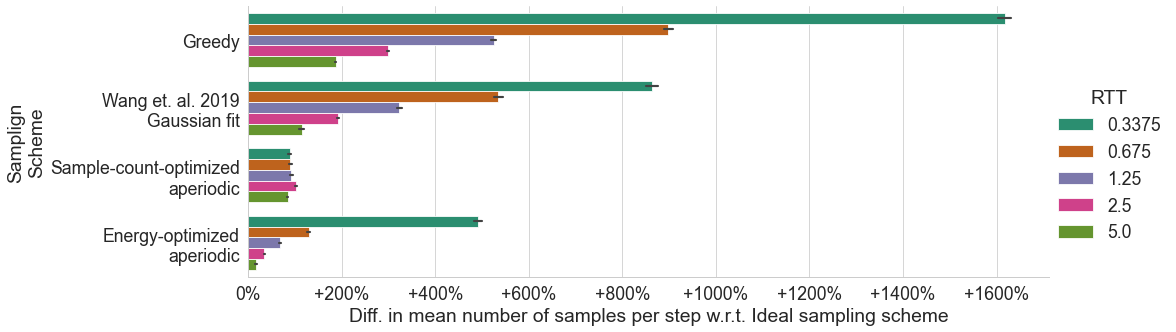

In [11]:
plot_data = samples_diff.set_index(["sampler", "rtt"])[["CI95_Low", "CI95_High", "diff"]].stack().reset_index().rename(
    columns={0: "values"})

fg = sns.catplot(
    kind="bar",
    data=plot_data,
    estimator=lambda e: sorted(e)[1],
    errorbar=lambda e: (min(e), max(e)),
    y="sampler",
    hue="rtt",
    x="values",
    aspect=3,
    # aspect=12 / height,
    # height=height,
)
fg.legend.set_title("RTT")
fg.set_axis_labels(f"Diff. in mean number of samples per step w.r.t. {reference_name} sampling scheme", "Samplign\nScheme")
# fg.set(xticks=np.linspace(-0.25, 0, 6))
for ax in fg.axes.flat:
    ax.xaxis.set_major_formatter(tkr.FuncFormatter(lambda x, p: f"{x:+0.0%}" if x != 0.0 else "0%"))
plt.show()

In [12]:
mean_wait_per_step = (
    results
    .groupby(["sampler", "rtt", "repetition"])
    ["wait_time"]
    .mean()
    # .groupby(["sampler", "rtt"])
    # .mean()
)

mean_wait_per_step

sampler  rtt     repetition
Greedy   0.3375  1             1.808529e-01
                 2             1.801138e-01
                 3             1.707918e-01
                 4             1.793999e-01
                 5             1.665448e-01
                                   ...     
Ideal    5.0000  96            1.776357e-17
                 97           -1.776357e-17
                 98           -2.664535e-17
                 99           -1.776357e-17
                 100          -4.440892e-17
Name: wait_time, Length: 2500, dtype: float64

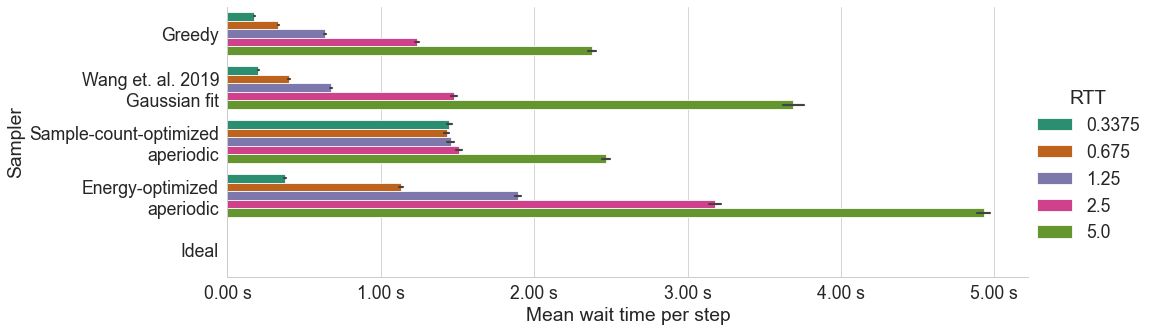

In [13]:
plot_data = mean_wait_per_step.reset_index()
# plot_data["rtt"] = plot_data["rtt"].apply(lambda s: f"{s:0.2f} s")

fg = sns.catplot(
    kind="bar",
    data=plot_data,
    x="wait_time",
    y="sampler",
    hue="rtt",
    aspect=3,
)
fg.set_axis_labels("Mean wait time per step", "Sampler")
# fg.set(xticks=list(np.linspace(0, 5, 6)) + list(np.linspace(6.0, 18.0, 7)))
fg.legend.set_title("RTT")
for ax in fg.axes.flat:
    ax.xaxis.set_major_formatter(tkr.FuncFormatter(lambda x, p: f"{x:0.2f} s"))
plt.show()

# push rtts up
# means that account for energy in idle or comm is more important than distributions
# super neurotic user

In [14]:
# class SuperNeuroticModel(ExpKernelRollingTTFETModel):
#     @staticmethod
#     def get_data() -> Tuple[
#         pd.DataFrame,
#         pd.arrays.IntervalArray,
#         pd.arrays.IntervalArray,
#         pd.arrays.IntervalArray,
#     ]:
#         scaling_factor_min: float = 0.25
#         scaling_factor_max: float = 4
#
#         data, *r = ExpKernelRollingTTFETModel.get_data()
#         # print(data)
#
#         old_min = data["exec_time"].min()
#         old_max = data["exec_time"].max()
#
#         new_min = old_min * scaling_factor_min
#         new_max = old_max * scaling_factor_max
#         new_range = new_max - new_min
#
#         data["exec_time"] = (data["exec_time"] - old_min) / (old_max - old_min)
#         data["exec_time"] = (data["exec_time"] * new_range) + new_min
#
#         return data, *r
#
#
# def superneurotic_experimental_run(
#         rtt: float,
#         proc_t: float,
#         P0: float,
#         Pc: float,
#         task_steps: int,
#         repetition: int,
# ):
#     tc = rtt - proc_t
#     calc_energy = lambda result: calculate_energy(P0, Pc, tc, result)
#
#     with warnings.catch_warnings():
#         warnings.simplefilter("ignore")
#         ground_truth = SuperNeuroticModel(neuroticism=1.0)
#         samplers: Dict[str, Sampler] = {
#             "Greedy"                                     : GreedySampler(),
#             "Ideal"                                      : IdealSampler(),
#             "Moothedath, original"                       : OptimumSampler(
#                 mean_exec_time_estimator=FittedNaiveExecutionTimeModel(dist=stats.rayleigh).get_mean_execution_time,
#                 alpha_calculator=lambda: tc * (Pc - P0),
#                 beta_calculator=lambda: P0
#             ),
#             "Moothedath et. al., superneurotic estimator": OptimumSampler(
#                 mean_exec_time_estimator=SuperNeuroticModel(neuroticism=1).get_mean_execution_time,
#                 alpha_calculator=lambda: tc * (Pc - P0),
#                 beta_calculator=lambda: P0
#             )
#         }
#
#     rows = deque()
#
#     for name, sampler in samplers.items():
#         ground_truth.reset()
#         prev_ttf = rtt
#
#         for step in range(1, task_steps + 1):
#             exec_time = ground_truth.advance(prev_ttf).get_execution_time()
#             sampling_result = sampler(exec_time, rtt)
#             energy = calc_energy(sampling_result)
#
#             ttf = sampling_result.duration - exec_time
#             wait_time = ttf - rtt
#
#             rows.append({
#                 "sampler"    : name,
#                 "rtt"        : rtt,
#                 "proc_time"  : proc_t,
#                 "P0"         : P0,
#                 "Pc"         : Pc,
#                 "repetition" : repetition,
#                 "step"       : step,
#                 "exec_time"  : exec_time,
#                 "duration"   : sampling_result.duration,
#                 "ttf"        : ttf,
#                 "wait_time"  : wait_time,
#                 "energy"     : energy,
#                 "num_samples": sampling_result.num_samples,
#             })
#
#             prev_ttf = ttf
#
#     df = pd.DataFrame(rows)
#     df["sampler"] = df["sampler"].astype(pd.CategoricalDtype(samplers.keys(), ordered=False))
#     return df
#
#
# processing_delay = 0.15
# rtts = np.array([0.2, 0.4, 0.8, 1.6, 3.2, 6.4])
#
# task_steps = 100
# repetitions = 100
#
# P0 = 0.015
# Pc = 0.045
#
# combinations = list(itertools.product(
#     rtts,
#     # [processing_delay],
#     # [P0],
#     # [Pc],
#     # [task_steps],
#     range(1, repetitions + 1)
# ))
#
# results = deque()
#
# with tqdm(total=len(combinations)) as bar, mp.Pool() as pool:
#     def _callback(df: pd.DataFrame):
#         results.append(df)
#         bar.update()
#
#
#     def _errback(error):
#         print(error)
#         raise error
#
#
#     for rtt, rep in combinations:
#         pool.apply_async(
#             superneurotic_experimental_run,
#             args=(rtt, processing_delay, P0, Pc, task_steps, rep),
#             callback=_callback,
#             error_callback=_errback,
#         )
#
#     pool.close()
#     pool.join()
#
# results = pd.concat(results, ignore_index=True)
# results

In [15]:
# mean_energy_per_step = (
#     results
#     .groupby(["sampler", "rtt", "repetition"])
#     ["energy"]
#     .mean()
#     # .groupby(["sampler", "rtt"])
#     # .mean()
# )
#
# plot_data = mean_energy_per_step.reset_index()
# plot_data["rtt"] = plot_data["rtt"].apply(lambda s: f"{s:0.2f} s")
#
# fg = sns.catplot(
#     kind="bar",
#     data=plot_data,
#     x="energy",
#     y="sampler",
#     hue="rtt",
#     aspect=3,
# )
# fg.set_axis_labels("Mean energy consumed per step", "Sampler")
# fg.legend.set_title("RTT")
# for ax in fg.axes.flat:
#     ax.xaxis.set_major_formatter(tkr.FuncFormatter(lambda x, p: f"{x * 1000:1.0f} mJ"))
# plt.show()
#
# mean_energy_per_step